In [11]:
import sqlite3
import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean 
import math

In [8]:
import scipy 
print(scipy.__version__) #должна быть 1.7.1

1.7.1


In [9]:
sns.set_theme()

Источник данных https://habr.com/ru/post/579492/

## Оглавление<a class="anchor" id="0-bullet"></a>:
* [Подготовка данных для анализа](#1.0-bullet) 
    * [Подключаем к базе данных и знакомимся с табличками](#1.1-bullet) 
    * [Формируем основную табличку для работы df_elect_result](#1.2-bullet) 
* [Общий визуальный анализ](#2.0-bullet)
    * [Результаты по районам](#2.1-bullet)
    * [Результаты по типу населенного пункта](#2.2-bullet)
    * [Результаты по УИКам в Кирове](#2.3-bullet)
    * [Выбросы по total_voters и elect_turnout, k-means](#2.4-bullet)
* [Анализ влияния наблюдателей](#3.0-bullet)
    * [Добавляем информацию о наблюдателях на участках](#3.1-bullet)
    * [Визуальный анализ данных в районах с большой долей участков с наблюдателями](#3.2-bullet)
    * [Статистический анализ влияния наблюдателей на явку](#3.3-bullet)
    * [Статистический анализ влияния наблюдателей на долю ЕР](#3.4-bullet)
* [Самый важный вывод](#3.5-bullet)

## Подготовка данных для анализа <a class="anchor" id="1.0-bullet"></a>
[Оглавление ↑](#0-bullet)

##### Подключаемя к базе данных election.sqlite3 <a class="anchor" id="1.1-bullet"></a>

In [4]:
conn = sqlite3.connect('election.sqlite3')    

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:859: UserWarning: The following variables cannot be serialized: conn
  warnings.warn(message)


Будем работать с двумя табличкиами: result и station

##### Таблица result - результаты голосования по участкам

In [5]:
df_result_table_sample = pd.read_sql_query("SELECT * FROM result limit 3", conn)
df_result_table_sample

,id,num,title,value,value_percent,Stationid
0,1,1,"Число избирателей, внесенных в список избирателей на момент окончания голосования",2153,None,1
1,2,6,Число погашенных избирательных бюллетеней,432,None,34
2,3,7,"Число избирательных бюллетеней, содержащихся в переносных ящиках для голосования",73,None,34


/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:859: UserWarning: The following variables cannot be serialized: conn
  warnings.warn(message)


- id - номер строки, ключ в таблице
- num - номер строки в протоколе
- title - название строки в протоколе
- value - численное значение
- value_percent - проценты для строк с результами партий
- Stationid - ключ из таблички station

In [6]:
# num - значения строчек в протоколах
pd.set_option('display.max_colwidth', -1)
pd.read_sql_query("SELECT distinct title, num FROM result order by num", conn)


##### Дальше будем использовать значения num:
     1   -  число избирателей на участке
     4+5 - число выданных бюллетеней
     17  - Единая Россия
     18  - Справедливая Россия
     15  - ЛДПР
     13  - КПРФ

##### Таблица station - параметры участка

In [7]:
df_station_table_sample = pd.read_sql_query("SELECT * FROM station limit 3", conn)
df_station_table_sample

,id,name,filename,path
0,1,УИК №614,C:\bench\IzbirkomData\out\9749042528738.html,"ЦИК России;Челябинская область;ОИК №189;Челябинск, Курчатовская;УИК №614"
1,2,УИК №812,C:\bench\IzbirkomData\out\4714008173572.html,ЦИК России;Тульская область;ОИК №183;Дубенская;УИК №812
2,3,УИК №813,C:\bench\IzbirkomData\out\4714008173573.html,ЦИК России;Тульская область;ОИК №183;Дубенская;УИК №813


/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:859: UserWarning: The following variables cannot be serialized: conn
  warnings.warn(message)


- id - ключ в таблице, Stationid в result
- name - название участка, неуникально: в разных регионах независимая нумерация
- path - иерархия участка, уникально

Проверяем, что нет дублей по участкам (по name, path или stationid)

In [8]:
pd.read_sql_query("""select * from
                      (SELECT name, path, count(distinct id) as dup_c FROM station group by name, path) 
                      where dup_c > 1""", conn)

,name,path,dup_c
0,None,,2


/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:859: UserWarning: The following variables cannot be serialized: conn
  warnings.warn(message)


In [9]:
pd.read_sql_query("""select distinct Stationid from
                      (SELECT Stationid, num, count(*) as dup_c FROM result group by Stationid, num) 
                      where dup_c > 1""", conn)

,Stationid


/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:859: UserWarning: The following variables cannot be serialized: conn
  warnings.warn(message)


##### Создаём основную табличку для работы - df_elect_result <a class="anchor" id="1.2-bullet"></a>
Оставляем только Кировскую область

In [10]:
df_elect_result = pd.read_sql_query("""
                    select 
                        Stationid,
                        name,
                        path,
                        total_voters,
                        voted_voters,
                        votes_for_er,
                        votes_for_sr,
                        votes_for_ldpr,
                        votes_for_com
                    from
                        (SELECT * FROM station 
                         where path like 'ЦИК России;Кировская область%'
                        ) as a
                    inner join
                        (select
                            Stationid,
                            sum(case when num = 1 then value else 0 end) as total_voters,
                            sum(case when num in (4,5) then value else 0 end) as voted_voters,
                            sum(case when num = 17 then value else 0 end) as votes_for_er,
                            sum(case when num = 18 then value else 0 end) as votes_for_sr,
                            sum(case when num = 15 then value else 0 end) as votes_for_ldpr,
                            sum(case when num = 13 then value else 0 end) as votes_for_com
                        from result
                        where num in (1, 4, 5, 15, 17, 18, 13)
                        group by Stationid
                        )as b 
                    on 
                        a.id = b.Stationid
                    --order by name
                    
                    """, 
                      conn)
     

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:859: UserWarning: The following variables cannot be serialized: conn
  warnings.warn(message)


In [11]:
conn.close()

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:859: UserWarning: The following variables cannot be serialized: conn
  warnings.warn(message)


##### В df_elect_result рассчитываем колонки и по station.path находим регион, округ и УИК

In [12]:
df_elect_result['elect_turnout'] = df_elect_result['voted_voters']/df_elect_result['total_voters']
for p in ['er', 'sr', 'com', 'ldpr']:
    df_elect_result['share_of_' + p] = df_elect_result['votes_for_' + p]/df_elect_result['voted_voters']

df_path = df_elect_result.loc[:, ['path']]
df_path['list_path'] = df_path['path'].apply(lambda x: x.split(';'))
df_path['count_path'] = df_path['list_path'].apply(lambda x: len(x))

def f_parse_path(path, num):
    list_path = path.split(';')
    if len(list_path) >= num + 1:
        return list_path[num]
    else:
        return ''
df_elect_result['region'] = df_elect_result['path'].apply(lambda x: f_parse_path(x,1))
df_elect_result['OIK'] = df_elect_result['path'].apply(lambda x: f_parse_path(x,2))
df_elect_result['district'] = df_elect_result['path'].apply(lambda x: f_parse_path(x,3))
df_elect_result['UIK_path'] = df_elect_result['path'].apply(lambda x: f_parse_path(x,4))

def get_uik_number(name):
    l = re.findall(r'[\d]+',name)
    if len(l) > 0 :
        return l[0]
    else:
        return ''
df_elect_result['UIK_number'] = df_elect_result['name'].apply(get_uik_number)

In [13]:
df_elect_result.head()

,Stationid,name,path,total_voters,voted_voters,votes_for_er,votes_for_sr,votes_for_ldpr,votes_for_com,elect_turnout,share_of_er,share_of_sr,share_of_com,share_of_ldpr,region,OIK,district,UIK_path,UIK_number
0,7102,Даровская,ЦИК России;Кировская область;ОИК №105;Даровская,7997,4564,1551,736,631,829,0.570714,0.339833,0.161262,0.181639,0.138256,Кировская область,ОИК №105,Даровская,,
1,7103,Зуевская,ЦИК России;Кировская область;ОИК №105;Зуевская,16786,8414,2869,1412,1152,1582,0.501251,0.340979,0.167816,0.188020,0.136915,Кировская область,ОИК №105,Зуевская,,
2,7104,Котельничская,ЦИК России;Кировская область;ОИК №105;Котельничская,11421,5295,1559,683,1092,833,0.463620,0.294429,0.128990,0.157318,0.206232,Кировская область,ОИК №105,Котельничская,,
3,7105,Лузская,ЦИК России;Кировская область;ОИК №105;Лузская,12880,6352,2111,1132,1001,1060,0.493168,0.332336,0.178212,0.166877,0.157588,Кировская область,ОИК №105,Лузская,,
4,7106,Мурашинская,ЦИК России;Кировская область;ОИК №105;Мурашинская,9279,4003,1318,565,492,854,0.431404,0.329253,0.141144,0.213340,0.122908,Кировская область,ОИК №105,Мурашинская,,


In [14]:
mask_district = (df_elect_result['name'] == df_elect_result['district'])
mask_number = (df_elect_result['name'] == df_elect_result['UIK_path'])
print('всего строк (ОИК+районы+УИКи)', df_elect_result.shape[0])
print("из них по ОИКам", df_elect_result.loc[~ (mask_district | mask_number)].shape[0])
print('из них по районам', mask_district.loc[mask_district].shape[0])
print('из них по УИКам', mask_district.loc[mask_number].shape[0])


всего строк (ОИК+районы+УИКи) 1222
из них по ОИКам 2
из них по районам 50
из них по УИКам 1170


In [18]:
df_elect_result.to_csv('df_elect_result.csv')

## Общий анализ <a class="anchor" id="2.0-bullet"></a>
[Оглавление ↑](#0-bullet)

In [4]:
from lib_nice_graphs import *

In [5]:
df_elect_result = pd.read_csv('df_elect_result.csv')
mask_district = (df_elect_result['name'] == df_elect_result['district'])
mask_number = (df_elect_result['name'] == df_elect_result['UIK_path'])

#### Результаты по районам <a class="anchor" id="2.1-bullet"></a>

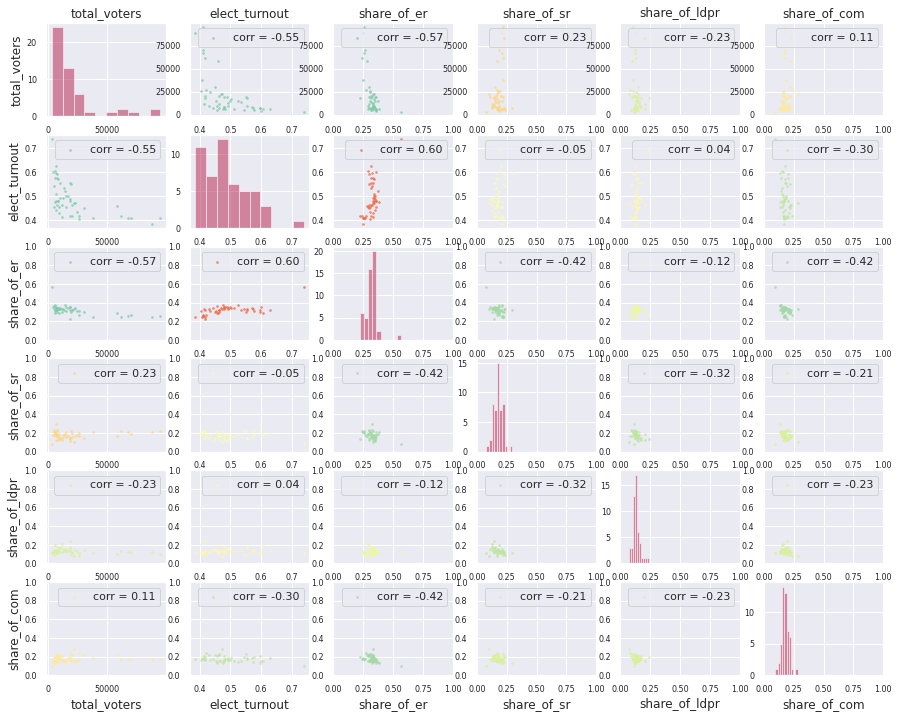

In [6]:
# Оставляем только строчки с результатами по районам df_district_result
df_district_result = df_elect_result.loc[(mask_district)]

metric_list = ['total_voters', 'elect_turnout', 'share_of_er', 'share_of_sr', 'share_of_ldpr', 'share_of_com']
fun_corr_matrix_w_scatters(df_district_result.loc[:,metric_list])

В районах с небольшим населением явка и доля ЕР выше (corr = - 0.55 и -0.57). В целом это соответсвует нашей картине мира: в сельских районах меньше избирателей, и они более возрастные и консервативные. В следующем пункте мы в этом убедимся.

Других значимых корреляций нет.

#### Результаты по типу населенного пункта: <a class="anchor" id="2.2-bullet"></a>
 - Киров
 - Крупные города (другие крупные города в Кировской области : Кирово-Чепецк, Слободской и Вятские Поляны)
 - Остальное (сельские районы)

In [7]:
df_uik_result = df_elect_result.loc[mask_number]
def fun_geo_group(district):
    big_city_list = ['Кирово-Чепецкая городская', 'Слободская городская', 'Вятскополянская городская']
    if 'Киров, ' in district:
        return 'Киров'
    elif max(city in district for city in big_city_list):
        return 'Крупные города'
    else:
        return 'Остальное'
df_uik_result.loc[:,'geo_group'] = df_uik_result.loc[:, 'district'].apply(fun_geo_group)

df_uik_pivot = df_uik_result.groupby('geo_group').agg({'Stationid': 'count', 
                                        'total_voters' : 'sum',
                                        'voted_voters' : 'sum',
                                        'votes_for_er' : 'sum',
                                        'votes_for_sr' : 'sum',
                                        'votes_for_ldpr' : 'sum',
                                        'votes_for_com' : 'sum'})
df_uik_pivot.loc[:, 'elect_turnout'] = df_uik_pivot.apply(lambda x: round(x.voted_voters/x.total_voters, 2), axis = 1)
df_uik_pivot.loc[:, ['Stationid', 'total_voters', 'voted_voters', 'elect_turnout']]

/home/jupyter/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,Stationid,total_voters,voted_voters,elect_turnout
geo_group,,,,
Киров,242,420094,170541,0.41
Крупные города,78,110090,48083,0.44
Остальное,850,498368,244764,0.49


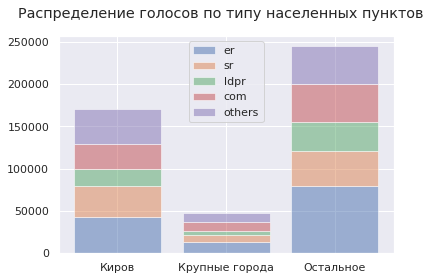

In [8]:
df_uik_pivot.loc[:, 'votes_for_others'] = df_uik_pivot.apply(lambda x: x.voted_voters - x.votes_for_er - x.votes_for_sr - x.votes_for_ldpr - x.votes_for_com, axis = 1)
fig, ax = plt.subplots()
index_list = list(df_uik_pivot.index)
part_list = ['er', 'sr', 'ldpr', 'com', 'others']
bottom_array = np.array([0,0,0])
for i in part_list:
    i_array = np.array(df_uik_pivot.loc[:,'votes_for_'+i])
    ax.bar(index_list, i_array, alpha = 0.5, bottom = bottom_array)
    bottom_array = bottom_array + i_array
ax.legend(part_list)
fig.suptitle('Распределение голосов по типу населенных пунктов')
plt.show()

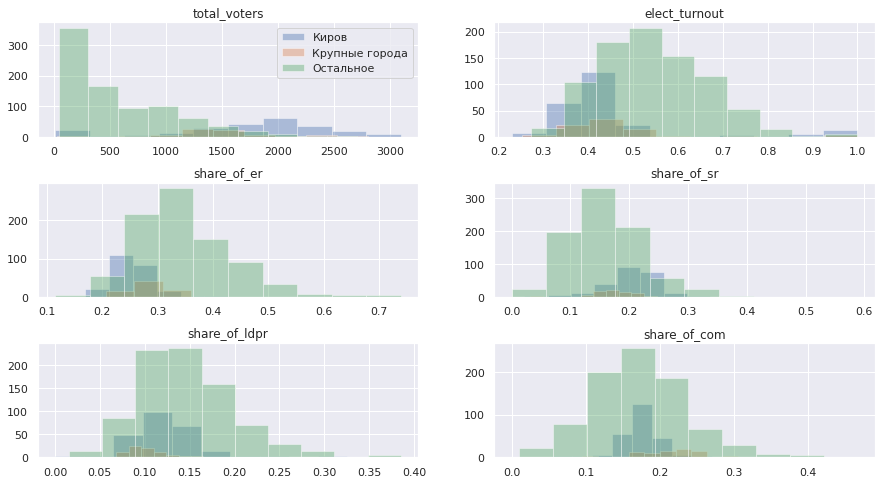

In [9]:
geo_group_list = ['Киров', 'Крупные города', 'Остальное']
fun_draw_six_gr(df_uik_result, 'geo_group', geo_group_list)

Наблюдения:
- в Кирове и круппых городах УИКи более крупные, а явка ниже, чем в Остальных
- поддержка ЕР в сельской местности (Остальные) выше, чем в городах
- поддержка СР в Кирове выше, чем в сельской местности и крупных городах
- поддержка ЛДПР в Кирове и сельской местности сравнима и больше, чем в крупных городах
- поддержка КПРФ в Кирове и сельской местности сравнима и меьше, чем в крупных гоодах

Важный вывод:

Идёт борьба между сельскими районами и Кировом. Кол-во проголосовавших в них за СР сравнимо, а за ЕР в два раза выше в сельских районах. 
Если мы будем увеличивать явку в городе и стягивать голоса от разных партий к одной (например, СР как наиболее сильной в городе), то ЕР уже не будет первой.

#### Результаты по УИКам в Кирове <a class="anchor" id="2.3-bullet"></a>

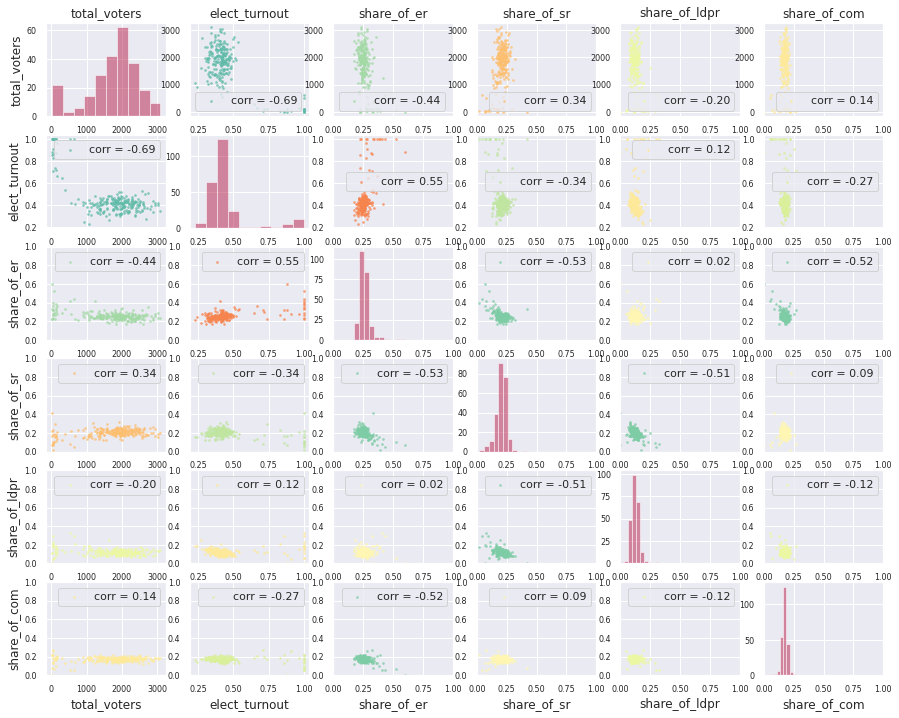

In [10]:
df_uik_result_kirov = df_uik_result.loc[df_uik_result['geo_group'] == 'Киров']
fun_corr_matrix_w_scatters(df_uik_result_kirov.loc[:, metric_list])

##### По осям total_voters и elect_turnout есть явные выбросы.  <a class="anchor" id="2.4-bullet"></a>
Они могут существенно влиять на корреляции, поэтому сначала поработаем с ними и после вернёмся к этому графику.

Вспомним, что такое k-means и с помощью этого пакета найдём выбросы.

In [11]:
from sklearn.cluster import KMeans 
from sklearn import preprocessing

In [12]:
# глазами видим два кластера: нормальные УИК-и и выбросы
k_means = KMeans(init = "k-means++", n_clusters = 2, n_init = 20)

X = df_uik_result_kirov.loc[:,['total_voters', 'elect_turnout']].to_numpy()
# нормализуем, просто нормируя на максимум, это даёт хороший результат и у нас нет предпосылок использовать более сложные нормировки
norm_X = preprocessing.normalize(X, norm = 'max', axis = 0)
k_means.fit(norm_X)
k_means_labels = k_means.labels_

In [13]:
df_uik_result_kirov.loc[:,'outliner'] = k_means_labels

/home/jupyter/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


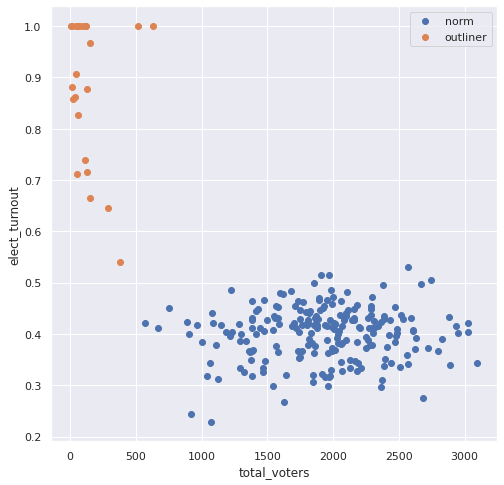

In [14]:
df = df_uik_result_kirov
fig, ax = plt.subplots()
for i in [0,1]:
    df_tmp = df[df['outliner'] == i]
    ax.scatter(df_tmp['total_voters'], df_tmp['elect_turnout'])
ax.legend(['norm','outliner'])
ax.set_xlabel('total_voters')
ax.set_ylabel('elect_turnout')
fig.set_size_inches(8,8)
fig.show()

Объяснение выбросов:
Я распарсила сайт ЦИК http://cikrf.ru/digital-services/naydi-svoy-izbiratelnyy-uchastok/?do=address

Практически по всем УИКам там есть информация о составе комиссии и месторасположеию.

Но у некоторых УИКов нет этой информации (просто пустая страничка). Я предполагаю, что это временные участки в больницах, тюрьмах и тд. Ожидаемо, что там большая явка и большая доля ЕР.

Пересечение наших аутсайдеров и таких бесхозных УИКов практически полное:

In [15]:
out_mask = df_uik_result_kirov['outliner'] == 1
outliner_list = [int(i) for i in list(df_uik_result_kirov.loc[out_mask]['UIK_number'])]

pd_uik_address = pd.read_csv('UIK_address.csv')
null_adress_list = list(pd_uik_address.loc[pd_uik_address['UIK_address'].isnull()]['UIK_number_int'])

In [16]:
print('уики без данных на сайте цик: ', len(null_adress_list))
print('аутлайнеры: ', len(outliner_list))
print('пересечение бесхозные уиков и аутлайнеров: ', len([i for i in outliner_list if i in null_adress_list]))

уики без данных на сайте цик:  30
аутлайнеры:  25
пересечение бесхозные уиков и аутлайнеров:  24


Возвращаемся к нашему большому графику, предварительно убрав УИКи без данных:

In [19]:
null_adress_msk = df_uik_result_kirov['UIK_number'].isin([i for i in null_adress_list])
df_uik_result_kirov_cl = df_uik_result_kirov.loc[~null_adress_msk]

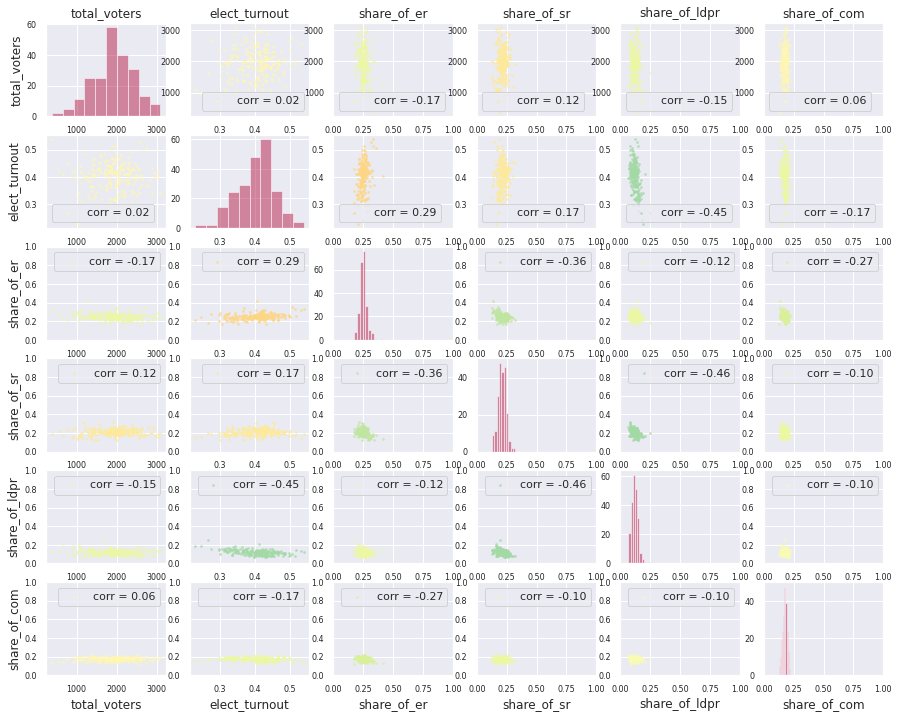

In [20]:
fun_corr_matrix_w_scatters(df_uik_result_kirov_cl.loc[:,metric_list])

Теперь мы видим, что по УИКам в Кирове нет сильных корреляций.

Можно немного поспекулировать про доли СР и ЛДПР - у них corr = -0.46. Возможно, это говорит о том, что электораты этих партий пересекаются.

Но такого же красивого объяснение про связь доли ЛДПР и явки у меня нет.

df_uik_result_kirov_cl - табличка с для дальнейшего анализа, сохраняемся

In [22]:
df_uik_result_kirov_cl.to_csv('df_uik_result_kirov_cl.csv')

## Анализ влияния наблюдателей <a class="anchor" id="3.0-bullet"></a>
[Оглавление ↑](#0-bullet)

* [Добавляем информацию о наблюдателях на участках](#3.1-bullet)
* [Визуальный анализ данных в районах с большой долей участков с наблюдателями](#3.2-bullet)
* [Статистический анализ влияния наблюдателей на явку](#3.3-bullet)
* [Статистический анализ влияния наблюдателей на долю ЕР](#3.4-bullet)

In [4]:
from lib_nice_graphs import *
df_uik_result_kirov_cl = pd.read_csv('df_uik_result_kirov_cl.csv')

#### Добавляем информацию о наблюдателях на участках <a class="anchor" id="3.1-bullet"></a>

In [5]:
# данные Голоса (признан иноагентом)
df_golos_data = pd.read_csv('golos_data.csv')
df_golos_data.head(3)

,vremya-MSK,region,UIK,nabludatel,organizatsiya,kontrolnye-sootnosheniya-soshlis,Коммунистическая партия Российской Федерации,Зелёные,ЛДПР,Новые люди,...,Партия Роста,Российская партия свободы и справедливости,Коммунисты России,Гражданская платформа,Зелёная альтернатива,Родина,Российская партия пенсионеров за социальную справедливость,Кол-во избирателей в списке,Число недействительных бюллетеней,Число действительных бюллетеней
0,2021-09-18 09:53,Московская область,5028,......5515,nomer-ne-akkreditovan,n,20,30,20,50,...,20,35,40,25,60,28,34,200,10,2000
1,2021-09-19 15:07,Сахалинская область,21,......5527,nomer-ne-akkreditovan,y,27,1,14,11,...,0,0,1,0,1,0,0,200,0,97
2,2021-09-19 15:27,Хабаровский край,468,......4567,nomer-ne-akkreditovan,y,99,3,50,26,...,0,9,3,1,3,1,22,826,8,289


In [6]:
# оставляем только зарегистрированные номера
mask_org = (df_golos_data['organizatsiya']!= 'nomer-ne-akkreditovan')
mask_city = (df_golos_data['region'] == 'Кировская область')
df_golos_city = df_golos_data.loc[mask_org & mask_city]

uik_nabl_kirov_list = [str(i) for i in list(df_golos_city['UIK'])]
df_uik_result_kirov_cl.loc[:,'UIK_number'] = df_uik_result_kirov_cl.loc[:,'UIK_number'].apply(lambda x: str(int(float(x))))

df_uik_result_kirov_cl.loc[:,'nabl_flg'] = df_uik_result_kirov_cl.loc[:,'UIK_number'].apply(lambda x: x in uik_nabl_kirov_list)

In [7]:
district_list = list(df_uik_result_kirov_cl['district'].drop_duplicates())
for district in district_list:
    df_tmp = df_uik_result_kirov_cl.loc[df_uik_result_kirov_cl['district'] == district]
    t = df_tmp['nabl_flg'].shape[0]
    n = t - df_tmp['nabl_flg'].value_counts()[False]
    suptitle = district + ', уиков всего: ' + str(t) + ', с наблюдателями: ' + str(n)
    fun_draw_six_gr(df_tmp, 'nabl_flg', [True,False], suptitle)
    

Районы отличаются друг от друга и по данным, и по доле УИКов с наблюдателями.

Поэтому их нужно анализировать отдельно.

Но давайте явно докажем, что доля наблюдателей на УИКах  разная.

Если бы доля была одинаковая, то можно написать такую регрессию: УИКи с наблюдателями = k * все УИКи

Если R^2 будет большим, то связь есть и наоборот. 

In [9]:
# считаем всего уиков по районам
df_tmp_1 = pd.DataFrame(df_uik_result_kirov_cl.groupby(['district'])['name'].count())
df_tmp_1.rename({'name' : 'uik total cnt'}, axis = 1, inplace = True)

# считаем уиков с наблюдателями по районам
nabl_mask = df_uik_result_kirov_cl['nabl_flg'] == True
df_tmp_2 = pd.DataFrame(df_uik_result_kirov_cl[nabl_mask].groupby('district')['name'].count())
df_tmp_2.rename({'name' : 'uik w nabl cnt'}, axis = 1, inplace = True)

df_for_lin_reg = df_tmp_1.merge(df_tmp_2, on = 'district', how = 'left').fillna(0)

LinregressResult(slope=0.33953488372093027, intercept=-6.6697674418604675, rvalue=0.5847020639681896, pvalue=0.2228948526888215, stderr=0.23554477550043204, intercept_stderr=8.862453692493713)


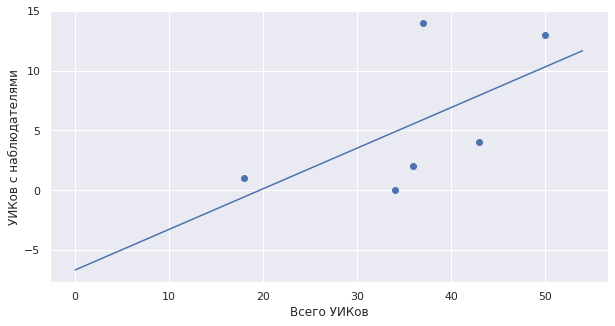

In [10]:
x = np.asanyarray(df_for_lin_reg['uik total cnt'])
y = np.asanyarray(df_for_lin_reg['uik w nabl cnt'])
res = stats.linregress(x,y)
print(res)
#The p-value for a hypothesis test whose null hypothesis is that the slope is zero, 
#using Wald Test with t-distribution of the test statistic. 

fig, ax = plt.subplots()
x = [i for i in range(0,55)]
y = [(res.intercept + i*res.slope) for i in x]
ax.scatter(df_for_lin_reg['uik total cnt'], df_for_lin_reg['uik w nabl cnt'])
ax.plot(x,y)
ax.set_xlabel('Всего УИКов')
ax.set_ylabel('УИКов с наблюдателями')
fig.set_size_inches(10,5)
fig.show()

Очевидно, что связь очень слабая и мы не можем отвергунть нулевую гипотезу, что связи между данными нет:
- k = -0.34 +- 1.96*0.24
- pvalue = 0.22 

In [11]:
df_for_lin_reg

,uik total cnt,uik w nabl cnt
district,,
"Киров, Ленинская 1",43,4.0
"Киров, Ленинская 2",50,13.0
"Киров, Нововятская",18,1.0
"Киров, Октябрьская 1",36,2.0
"Киров, Октябрьская 2",34,0.0
"Киров, Первомайская",37,14.0


Для дальнейшего анализа оставляем только: 
- Киров, Первомайская 
- Киров, Ленинская 2

так как там адекватное кол-во наблюдателей

#### Визуальный анализ данных в районах с большой долей участков с наблюдателями <a class="anchor" id="3.2-bullet"></a>

In [12]:
norm_district_list = ['Киров, Первомайская','Киров, Ленинская 2']

In [13]:
for district in norm_district_list:
    df_tmp = df_uik_result_kirov_cl.loc[df_uik_result_kirov_cl['district'] == district]
    t = df_tmp['nabl_flg'].shape[0]
    n = t - df_tmp['nabl_flg'].value_counts()[False]
    suptitle = district + ', уиков всего: ' + str(t) + ', с наблюдателями: ' + str(n)
    fun_draw_six_gr(df_tmp, 'nabl_flg', [True,False], suptitle)

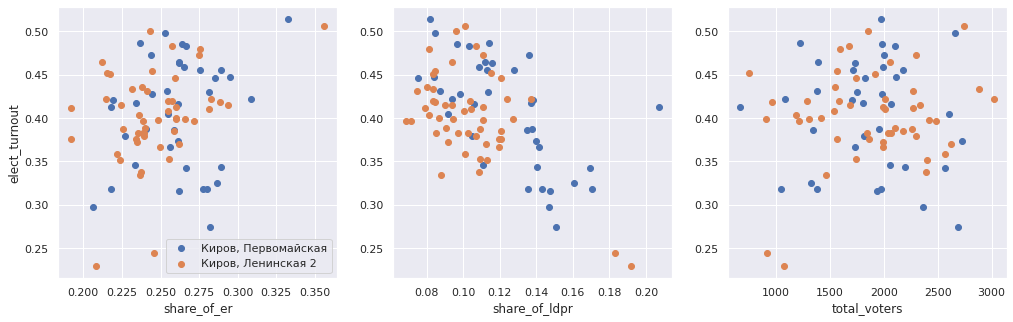

In [14]:
# Видим два выброса: большая явка и большая доля ер
fig, ax = plt.subplots(1,3)
for d in norm_district_list:
    mask = df_uik_result_kirov_cl['district'] == d
    Y = df_uik_result_kirov_cl.loc[mask,['elect_turnout']]
    X = df_uik_result_kirov_cl.loc[mask,['share_of_er']]
    ax[0].scatter(X,Y)
    X = df_uik_result_kirov_cl.loc[mask,['share_of_ldpr']]
    ax[1].scatter(X,Y)
    X = df_uik_result_kirov_cl.loc[mask,['total_voters']]
    ax[2].scatter(X,Y)
    
ax[0].legend(norm_district_list)
ax[0].set_xlabel('share_of_er')
ax[0].set_ylabel('elect_turnout')
ax[1].set_xlabel('share_of_ldpr')
ax[2].set_xlabel('total_voters')


fig.set_size_inches(17,5)
fig.show()

Интересно, где расположены эти два участка с низкой явкой и долей ЕР, зато высокой долей ЛДПР, и где расположены два участка с высокой явкой и долей ЕР.  (На этих участках не было наблюдателей)

Надо будет нарисовать на карте)

In [15]:
love_er_list = list(df_uik_result_kirov_cl.loc[df_uik_result_kirov_cl['elect_turnout'] > 0.5]['path'])
love_ldpr_list = list(df_uik_result_kirov_cl.loc[df_uik_result_kirov_cl['elect_turnout'] < 0.25]['path'])

In [16]:
print('love_er_list: ', love_er_list)
print('love_ldpr_list: ', love_ldpr_list)

love_er_list:  ['ЦИК России;Кировская область;ОИК №105;Киров, Октябрьская 1;УИК №404', 'ЦИК России;Кировская область;ОИК №105;Киров, Октябрьская 2;УИК №384', 'ЦИК России;Кировская область;ОИК №106;Киров, Ленинская 2;УИК №331', 'ЦИК России;Кировская область;ОИК №105;Киров, Первомайская;УИК №461', 'ЦИК России;Кировская область;ОИК №106;Киров, Ленинская 1;УИК №300']
love_ldpr_list:  ['ЦИК России;Кировская область;ОИК №106;Киров, Ленинская 2;УИК №336', 'ЦИК России;Кировская область;ОИК №106;Киров, Ленинская 2;УИК №332']


In [17]:
df_uik_result_kirov_cl.to_csv('df_uik_result_kirov_cl_w_nabl.csv')

#### Статистический анализ влияния наблюдателей на явку <a class="anchor" id="3.3-bullet"></a>

Явка - это конверсия, то есть (кол-во пришедших)/(кол-во избирателей). По нашему сетапу кол-во избирателей (знаменатель) не может изменяться от наличия наблюдателя.

Поэтому при проверке гипотезы "Наблюдатели уменьшают явку" мы можем использовать и усредненную локальную явку - avg(локальная явка), и глобальную явку - sum(кол-во пришедших)/sum(кол-во избирателей)

Я решила протестировать четыре подхода:
- t-test для среднего локальной явки
- бутстреп для среднего локальной явки
- манна-уитни для среднего локальной явки
- z-test для глобальной доли

Для каждого из этих тестов я строю:
- распределение pvalue под Н0 (в аа тесте); оно должно быть равномерным;
- кумулятивную плотность вероятности pvalue, которое под Н0 по определению совпадает с FPR; этот график позволяет заключить, является ли pvalue хорошей оценкой для FPR (False Positive Rate);
- распределение метрики в группах а и б (без наблюдателей и с наблюдателями);
- распределение статистики с p_value в одно и двух сторонних тестах.

Два важных комментария:
1) Для первых двух графиков нам необходимо много раз провести аа тест. Я не уверена, что верно его делаю. Я фиксируют группу а = участки без наблюдателей. Группу б набираю из группы а, размер = кол-во участков с наблюдателями. Кажется, что такой подход должен приводить к более консервативным результатам, поэтому я остановилась на нём.
Но в жизни обычно у нас есть возможность сделать нормальный аа тест - взять данные за прошлый период без теста.

2) Цель этого мероприятия пощупать разные тесты. Но для серьёзного анализа таких данных я бы выбрала permutation test. Он хорошо работает на небольших выборках с непонятным распределением и тестирует гипотезу "Выборки относятся к одному распределению". 

In [13]:
from lib_tests import *

In [14]:
df_uik_result_kirov_cl = pd.read_csv('df_uik_result_kirov_cl_w_nabl.csv')

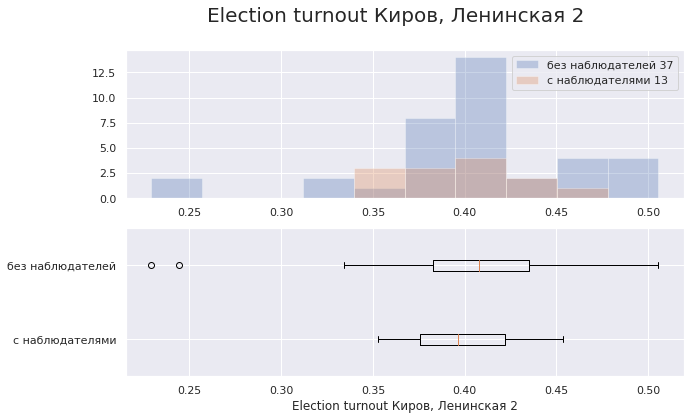

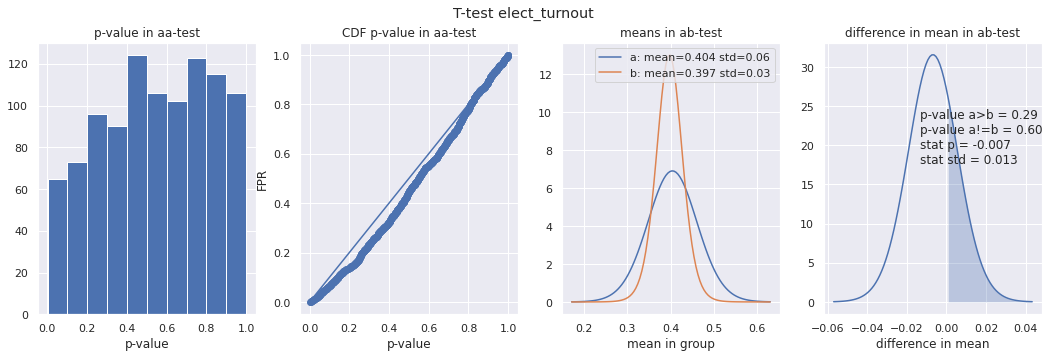

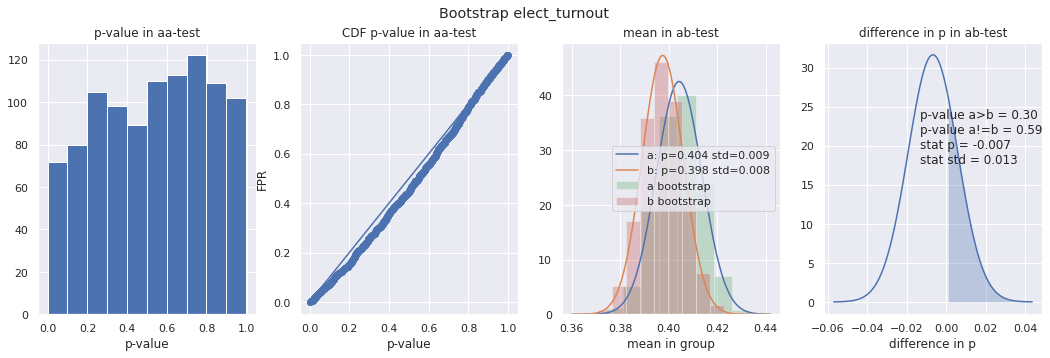

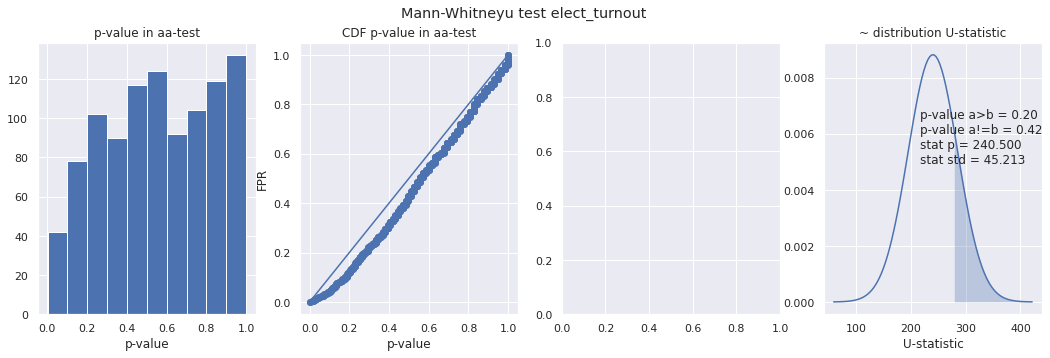

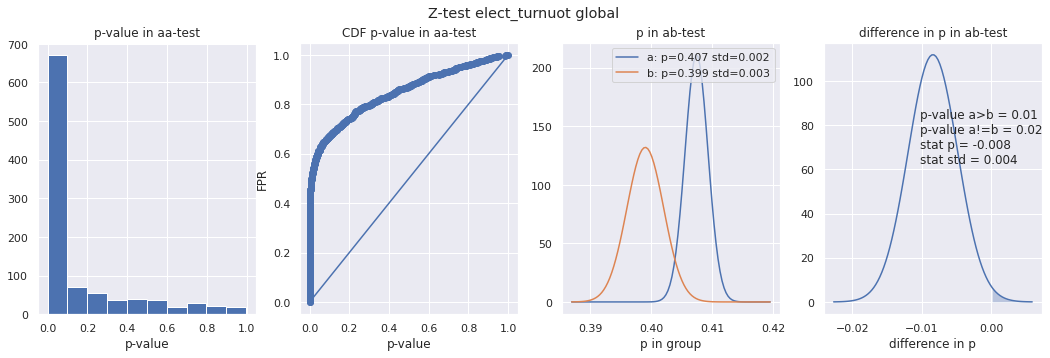

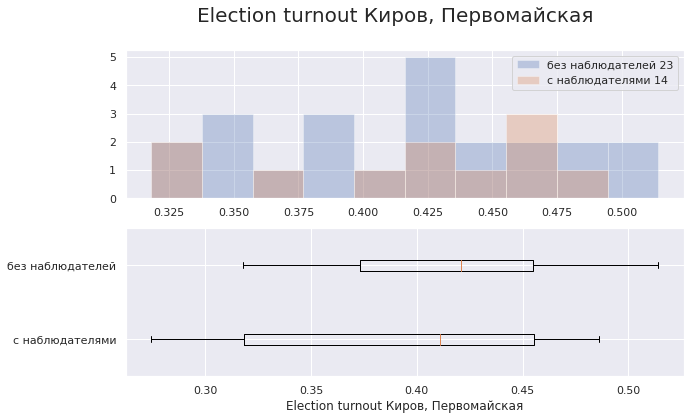

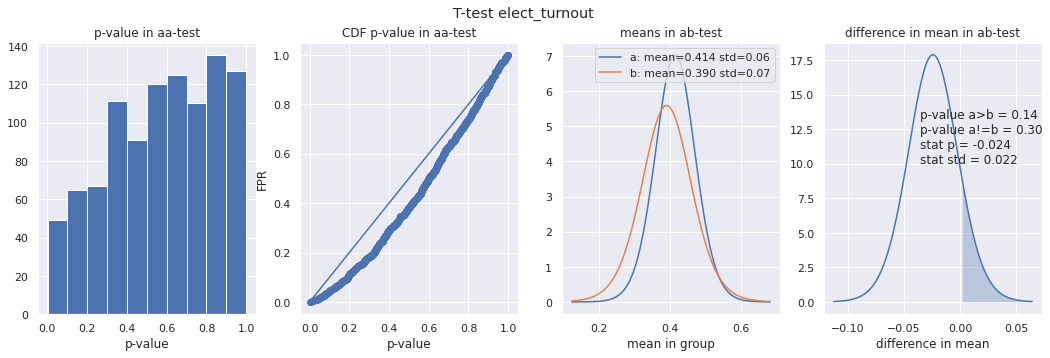

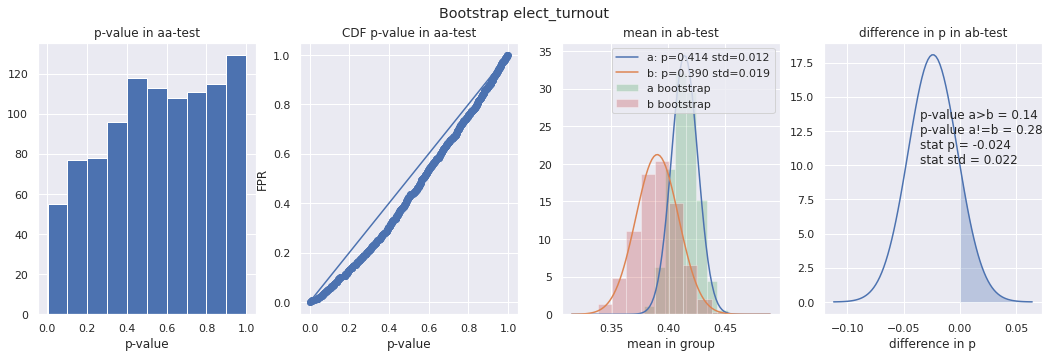

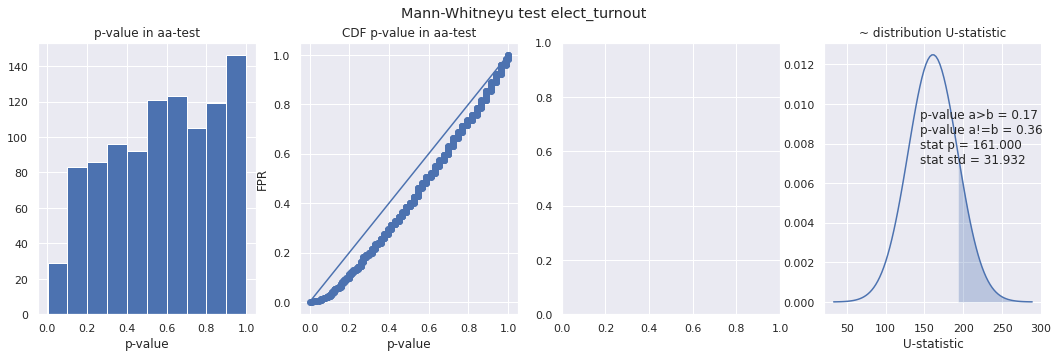

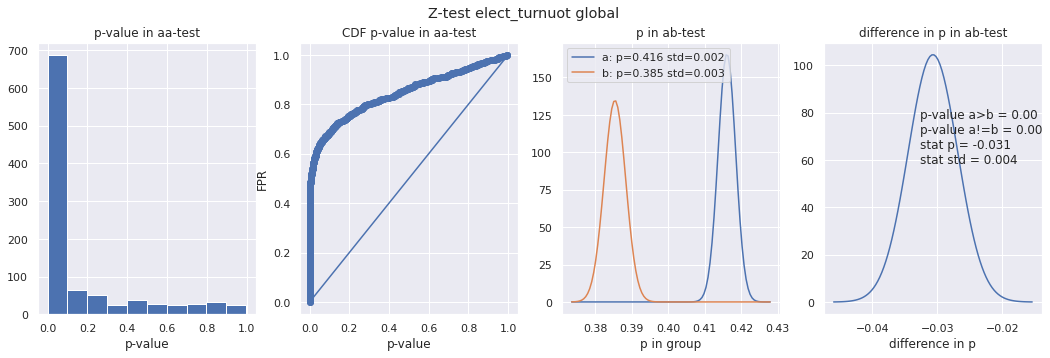

In [15]:
sns.set_theme()
for district in ['Киров, Ленинская 2', 'Киров, Первомайская']:
    mask_1 = df_uik_result_kirov_cl['district'] == district
    mask_2 = df_uik_result_kirov_cl['nabl_flg'] == False
    a_df = df_uik_result_kirov_cl[mask_1 &    mask_2 ].loc[:, ['elect_turnout', 'voted_voters', 'total_voters']]
    b_df = df_uik_result_kirov_cl[mask_1 & (~ mask_2)].loc[:, ['elect_turnout', 'voted_voters', 'total_voters']]

    fun_draw_distribution_nicely([a_df['elect_turnout'], b_df['elect_turnout']], 
                                 ['без наблюдателей'   , 'с наблюдателями'    ], 
                                 'Election turnout ' + district)
    fun_perfom_ttest(a_df, b_df, 'elect_turnout')
    fun_perfom_bootstrap(a_df, b_df, 'elect_turnout')
    fun_perfom_mannwhitneyu(a_df, b_df, 'elect_turnout')
    fun_perfom_ztest_for_global_share(a_df, b_df, 'voted_voters', 'total_voters', 'elect_turnuot global')

Выводы:
- мы не можем принять гипотезу, что наличие наблюдателей уменьшает явку;
- z-test в моём подходе очень недооценивает дисерсию (== FPR) и поэтому его нельзя использовать; это происходит из-за того, что 'пользователи' (избиратели) поделены по неравноценным 'бакетам' (УИКам);
- в остальных тестах мы, наоборот, немного переоценивает FPR, то есть склонны к более консервативным заключениям.

#### Статистический анализ влияния наблюдателей на долю ЕР <a class="anchor" id="3.4-bullet"></a>

Доля, проголосовавших за ЕР - конверсия, то есть (кол-во за ЕР)/(кол-во пришедших).

В нашем сетапе мы могли бы ожидать изменение знаменателя (кол-во пришедших). В этом случае, нам нужно было бы аккуратно подумать про бизнес задачу и про тестируемую гипотезу для того, чтобы правильно выбрать локальную или глобальную конверсию.

Но мы только что проверили, что явка не зависит от наличия наблюдателя. Поэтому и кол-во пришедших в целом не должно (наблюдатели распределялись рандомно).

Поэтому повторим предыдущий успех для доли проголосовавших за ЕР.

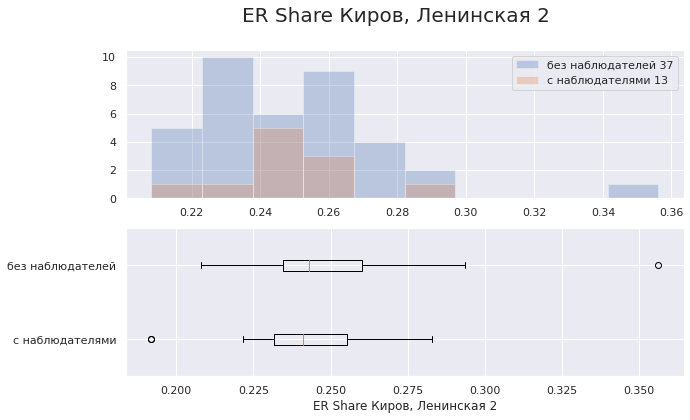

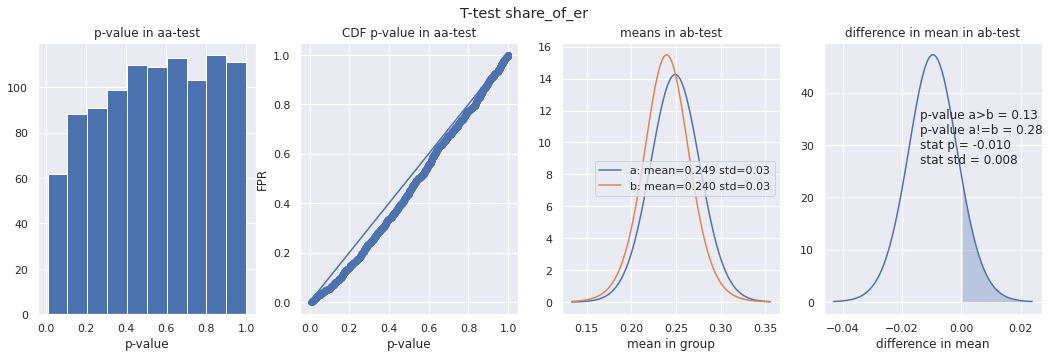

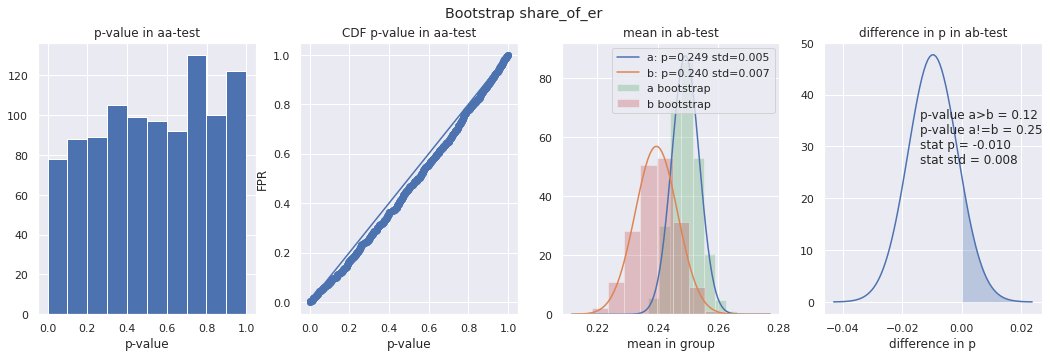

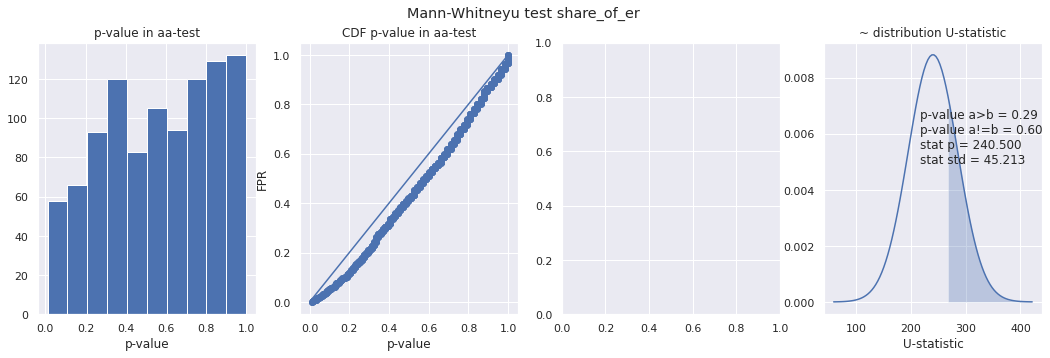

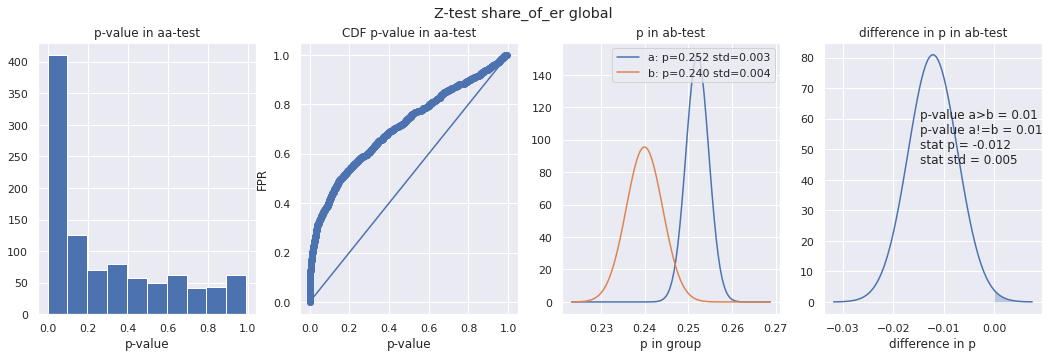

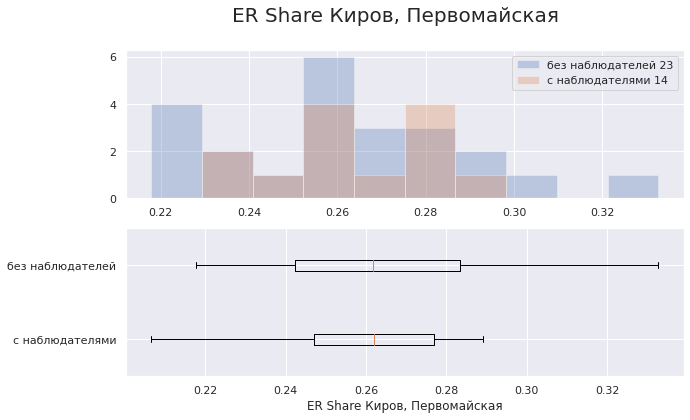

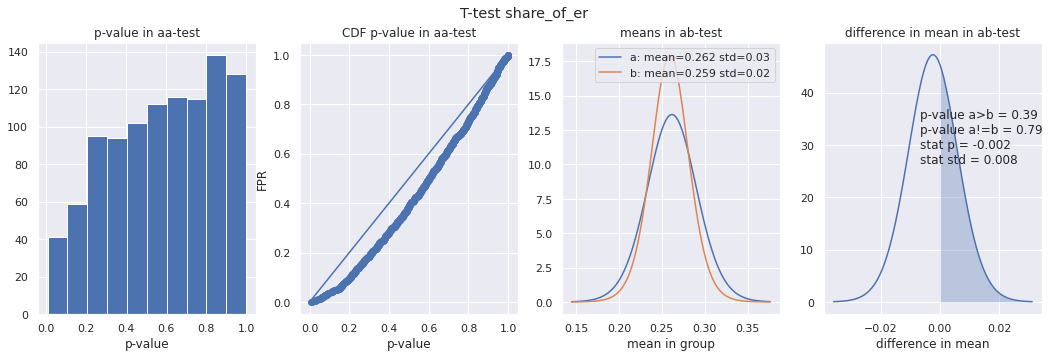

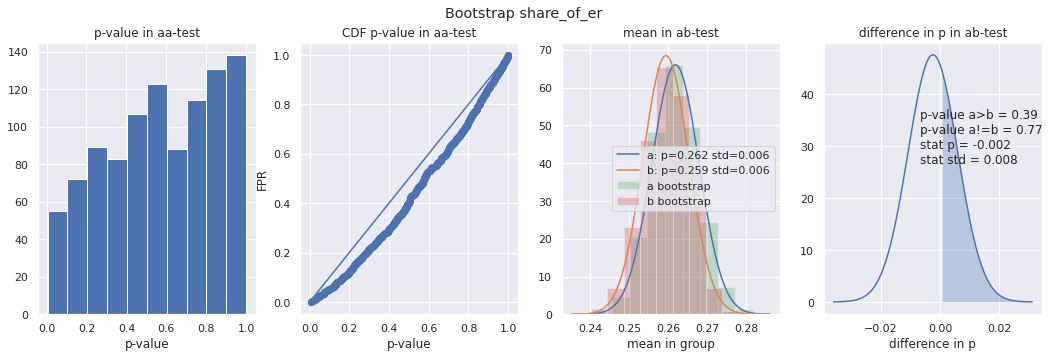

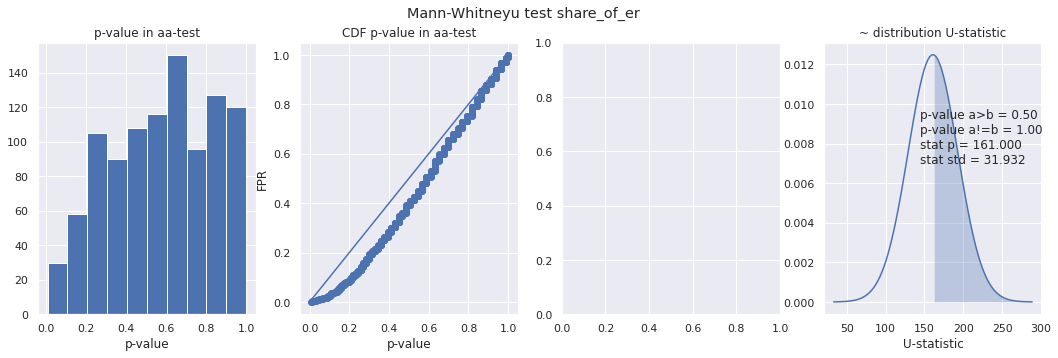

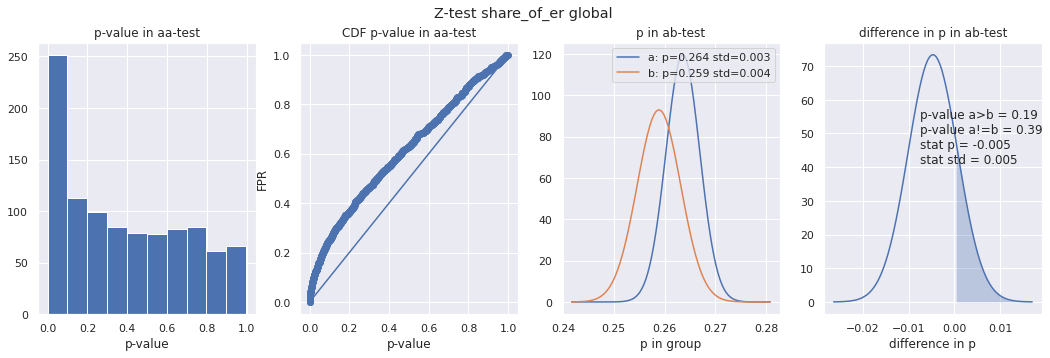

In [16]:
sns.set_theme()
for district in ['Киров, Ленинская 2', 'Киров, Первомайская']:
    mask_1 = df_uik_result_kirov_cl['district'] == district
    mask_2 = df_uik_result_kirov_cl['nabl_flg'] == False
    a_df = df_uik_result_kirov_cl[mask_1 &    mask_2 ].loc[:, ['voted_voters', 'votes_for_er', 'share_of_er']]
    b_df = df_uik_result_kirov_cl[mask_1 & (~ mask_2)].loc[:, ['voted_voters', 'votes_for_er', 'share_of_er']]

    fun_draw_distribution_nicely([a_df['share_of_er'], b_df['share_of_er']], 
                                 ['без наблюдателей'   , 'с наблюдателями'    ], 
                                 'ER Share ' + district)
    fun_perfom_ttest(a_df, b_df, 'share_of_er')
    fun_perfom_bootstrap(a_df, b_df, 'share_of_er')
    fun_perfom_mannwhitneyu(a_df, b_df, 'share_of_er')
    fun_perfom_ztest_for_global_share(a_df, b_df, 'votes_for_er', 'voted_voters', 'share_of_er global')

Выводы:
- мы не можем принять гипотезу, что наличие наблюдателей изменяет долю ЕР;
- z-test в моём подходе очень недооценивает дисерсию (== FPR) и поэтому его нельзя использовать; это происходит из-за того, что 'пользователи' (избиратели) поделены по неравноценным 'бакетам' (УИКам);
- в остальных тестах мы, наоборот, немного переоценивает FPR, то есть склонны к более консервативным заключениям.

## Самый главный вывод: <a class="anchor" id="3.5-bullet"></a>
- надо ходить на выборы, систематического изменения результатов на участках без наблюдателей в Кирове - нет! (ну вроде)
- надо наблюдать за выборами, чтобы данных было больше!